<a href="https://www.kaggle.com/code/avikumart/computervision-intel-image-classification-project?scriptVersionId=102115499" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

In this notebook, we will build image classification models to classify 6 categories of images; namely buildings, forest, glacier, mountain, sea, and street.

**Problem statement:** Build model that classifies 6 categories images from intel images dataset accuratly 

**Steps to be followed to solve this problem:**
1. load the dataset
2. label the dataset
3. visualize and explore the dataset
4. train the Deep neural net with CNN layers
5. train using pre-trained models from keras models

*this notebook is under progress*

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from skimage.io import imread, imshow
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras.utils import to_categorical
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random

# 1. Label and load the dataset

In [2]:
train_dir = '../input/intel-image-classification/seg_train/seg_train'
test_dir = '../input/intel-image-classification/seg_test/seg_test'
pred_dir = '../input/intel-image-classification/seg_pred/seg_pred'

In [3]:
# assign class labels
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [4]:
# usecase of os.listdir and os.path.join functions
for folder in os.listdir(train_dir):
    files_path = []
    for file in os.listdir(os.path.join(train_dir,folder)):
        files_path.append(file)
    print(len(files_path))

2512
2382
2191
2274
2271
2404


In [5]:
# define load_dataset function to load dataset with labels
def load_dataset():
    # create list of datasets
    datasets = [train_dir, test_dir]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            # assign labels to each folder images
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # read the image files stored in image_path
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
                
        # convert the images and labels list to numpy array
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output 

In [6]:
# load the data using above functions
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading ../input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:22<00:00, 105.10it/s]


Images file have been loaded
loading ../input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:03<00:00, 143.20it/s]


Images file have been loaded


In [7]:
print("train dataset size")
len(train_images), len(train_labels)

train dataset size


(14034, 14034)

In [8]:
print("test dataset size")
len(test_images), len(test_labels)

test dataset size


(3000, 3000)

# 2. Pre-process and explore image datasets

In [9]:
# shape of image dataset is 4D tensors
train_images.shape, test_images.shape

((14034, 150, 150, 3), (3000, 150, 150, 3))

In [10]:
# shuffle the train nad test datasets
(train_images, train_labels) = shuffle(train_images, train_labels, random_state=45)

In [11]:
(test_images, test_labels) = shuffle(test_images, test_labels, random_state=45)

In [12]:
# keeping 6000 data instances for training and testing our model
train_images = train_images[:6000]
train_labels = train_labels[:6000]

In [13]:
test_images = test_images[:1400]
test_labels = test_labels[:1400]

In [14]:
# normalize the images dataset
trn_images_norm = train_images/255.0
tst_images_norm = test_images/255.0

In [15]:
# let's see proportion of classes in train and test dataset
def proportion_labels(labels, dataset):
    series = pd.DataFrame(labels).reset_index()
    series.rename(columns = {0:'labels'}, inplace=True)
    final_s = series.groupby('labels').count().reset_index()                                          
    ticks1= [key for key in class_labels.keys()]
    
    # plot the pie chart and bar graph of labels
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.bar(np.array(final_s['labels']), np.array(final_s['index']))
    plt.xticks(ticks=np.array(final_s['labels']), labels=ticks1, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.grid(visible=True)
    plt.title("Number of images per class", size=14, weight='bold')
    
    plt.subplot(122)
    plt.pie(final_s['index'].ravel(),
            labels=ticks1,
            autopct='%1.2f%%',
            textprops={'fontweight':'bold'}
           )
    plt.title("proportion of classes", size=14, weight='bold')
    
    plt.suptitle(f"Proportion of {dataset} data", size=20, weight='bold')
    plt.show()
    
    return final_s

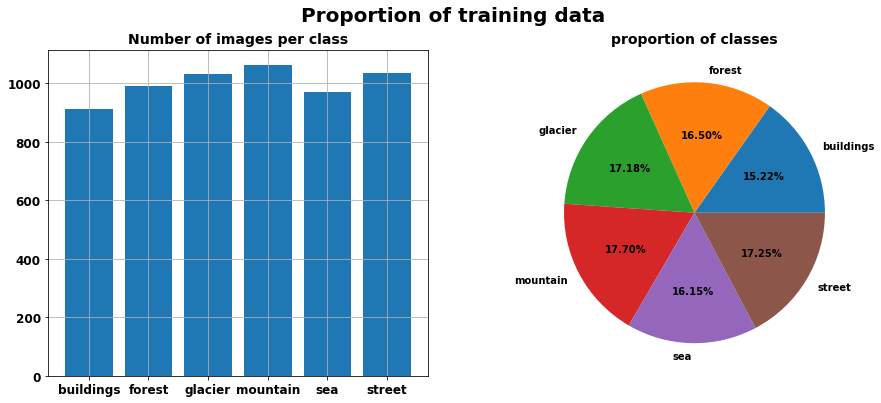

In [16]:
final_s = proportion_labels(train_labels, "training")

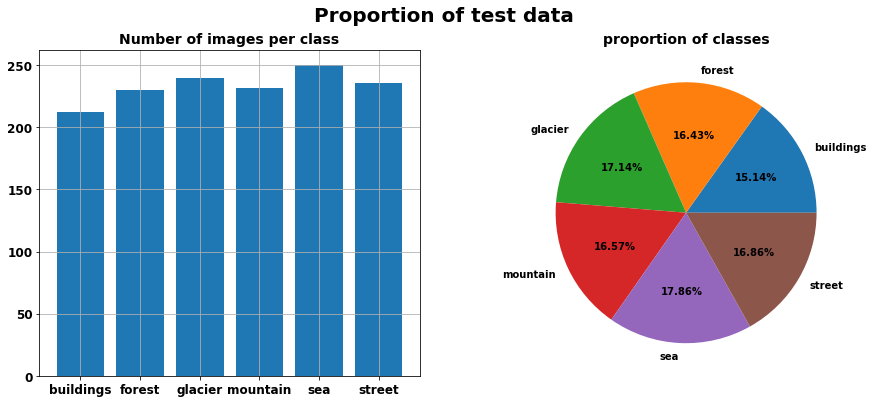

In [17]:
test_d = proportion_labels(test_labels, "test")

**Observation:**

**Our both training and test datasets are more or less equally distributed as we shuffled the dataset after loading and labeling**

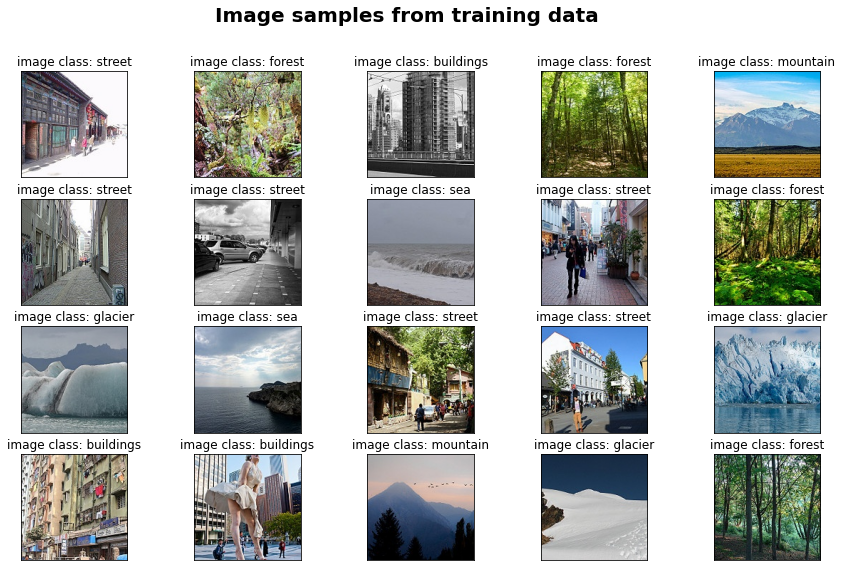

In [18]:
## plot 3*5 visualization of images
plt.figure(figsize=(15,9))
for idx, label in enumerate(train_labels[:20]):
    plt.subplot(4,5, idx+1)
    plt.imshow(trn_images_norm[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'image class: {class_names[label]}')   
    
plt.suptitle(f'Image samples from training data', size=20, weight='bold')
plt.show()

# 3. Deep neural network model using CNN layers

In [19]:
# model architecture of first keras model
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

2022-07-30 13:22:58.973723: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
# convert labels to categorical 
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# compile the model with 'adam' optimizer
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(trn_images_norm, train_labels, batch_size=128, epochs=15, validation_data=(tst_images_norm, test_labels),
                   callbacks=callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(tst_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

2022-07-30 13:23:02.080887: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
47/47 [==============================] - 54s 1s/step - loss: 1.4061 - accuracy: 0.4073 - val_loss: 1.2908 - val_accuracy: 0.4571


2022-07-30 13:23:57.194301: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/15
47/47 [==============================] - 53s 1s/step - loss: 1.1305 - accuracy: 0.5380 - val_loss: 1.0834 - val_accuracy: 0.5543
Epoch 3/15
47/47 [==============================] - 53s 1s/step - loss: 1.0160 - accuracy: 0.5918 - val_loss: 0.9993 - val_accuracy: 0.6200
Epoch 4/15
47/47 [==============================] - 54s 1s/step - loss: 0.9284 - accuracy: 0.6320 - val_loss: 0.9088 - val_accuracy: 0.6443
Epoch 5/15
47/47 [==============================] - 52s 1s/step - loss: 0.8807 - accuracy: 0.6600 - val_loss: 0.8924 - val_accuracy: 0.6679
Epoch 6/15
47/47 [==============================] - 52s 1s/step - loss: 0.8213 - accuracy: 0.6820 - val_loss: 0.8509 - val_accuracy: 0.6621
Epoch 7/15
47/47 [==============================] - 52s 1s/step - loss: 0.7824 - accuracy: 0.7093 - val_loss: 0.7995 - val_accuracy: 0.6957
Epoch 8/15
47/47 [==============================] - 53s 1s/step - loss: 0.7488 - accuracy: 0.7215 - val_loss: 0.7343 - val_accuracy: 0.7300
Epoch 9/15
47/47 [==

**Note:**

With 15 epochs and adam optimizer our test dataset accuracy comes around at 76-79% while our train accuracy stood at 80% at max.

This is the case of underfitting. to overcome underfitting, we need more deeper NN model to find highest accuracy. also we need to check where the error lies

In [21]:
# saving model in H5 format
model.save('image_classifier_cnn1.h5')

In [22]:
# load the prediction data and predict class on unseen data
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

images_paths = getImagePaths(pred_dir)
len(images_paths)

7301

In [23]:
file_array = []

for file in images_paths[:9]:
    files = cv2.imread(file)/255.0 
    file_array.append(files)
    
file_array = np.array(file_array)

# 4. Prediction on unseen image data

In [24]:
# vector of prected probability of each class by our model
predictions = model.predict(file_array)
predictions.shape

(9, 6)

In [25]:
# prediciton of 'index 0'image from 'preds_dir' image directory
preds_index = np.argmax(predictions, axis=1)
preds_index

array([4, 2, 3, 0, 3, 0, 4, 2, 4])

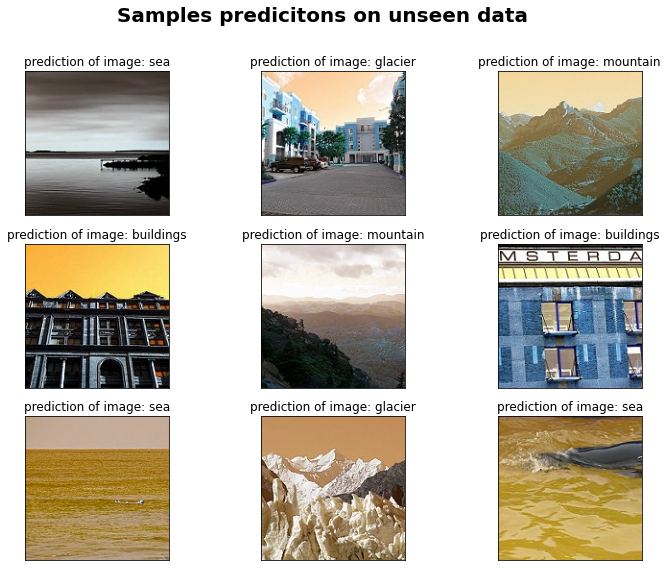

In [26]:
# sample prediciton on unseen data using model
plt.figure(figsize=(12,9))

for idx, i in enumerate(preds_index):
    plt.subplot(3,3, idx+1)
    plt.imshow(file_array[idx])
    plt.title(f"prediction of image: {class_names[i]}")
    plt.xticks([])
    plt.yticks([])
    
plt.suptitle("Samples predicitons on unseen data", size=20, weight='bold')
plt.show()

**Observation:**

We can learn that image index numbers 6 and 7 are not predicted correctly from our prediction dataset. we will do error dataset on validation dataset

# 5. Plot the Loss and accuracy curves

In [27]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

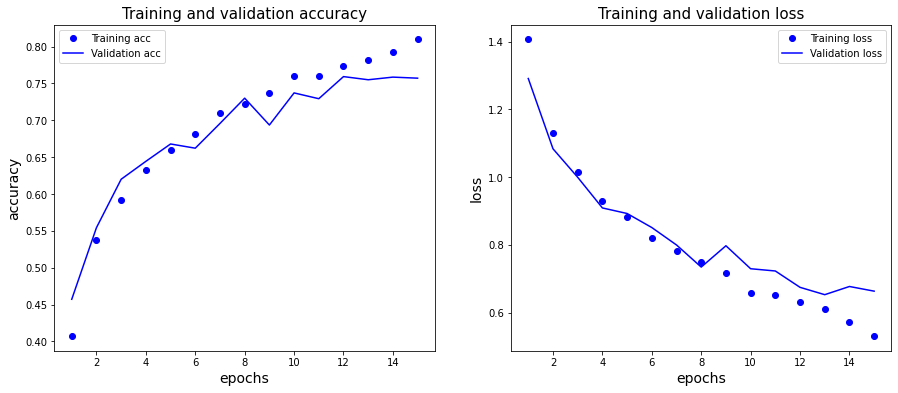

In [28]:
# call the function to plot the curves
plot_loss_accuracy(history)

# 6. Error analysis on test data

In [29]:
# prediction on validation data to check the errors
preds = model.predict(tst_images_norm)
print("Shape of the prediction indexs", preds.shape)

# apply argmax function over a rows to find 
predictions_f = np.argmax(preds, axis=1)
print("Shape of predicitons vector:", predictions_f.shape)

Shape of the prediction indexs (1400, 6)
Shape of predicitons vector: (1400,)


In [30]:
# convert categorical test labels to numpy array of 1 dim
test_list = []
for i in test_labels:
    index1 = list(np.argwhere(i).reshape(1))[0]
    test_list.append(index1)

test_array = np.array(test_list)
print("shape of actual test array:", test_array.shape)

shape of actual test array: (1400,)


In [31]:
def mislabled_images(class_names, test_images, test_labels, predicted_labels):
    # find the  mislabeled images using np.where and return array of mislabled images
    mislabels = (test_labels == predicted_labels)
    mislabels_index = np.array(np.where(mislabels == False)).ravel()
    mislables_images = test_images[mislabels_index]
    mislables_labels = predicted_labels[mislabels_index]
    
    print("Number of total mislabeled images", mislables_labels.shape)
    
    # plot the 20 mislabeled images
    plt.figure(figsize=(15,9))
    for idx, label in enumerate(mislables_labels[:20]):
        plt.subplot(4,5, idx+1)
        plt.imshow(mislables_images[idx])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Predicted class: {class_names[label]}')   
    
        plt.suptitle(f'Mislabeled images from test data', size=20, weight='bold')
    plt.show()  
    return mislables_labels

Number of total mislabeled images (340,)


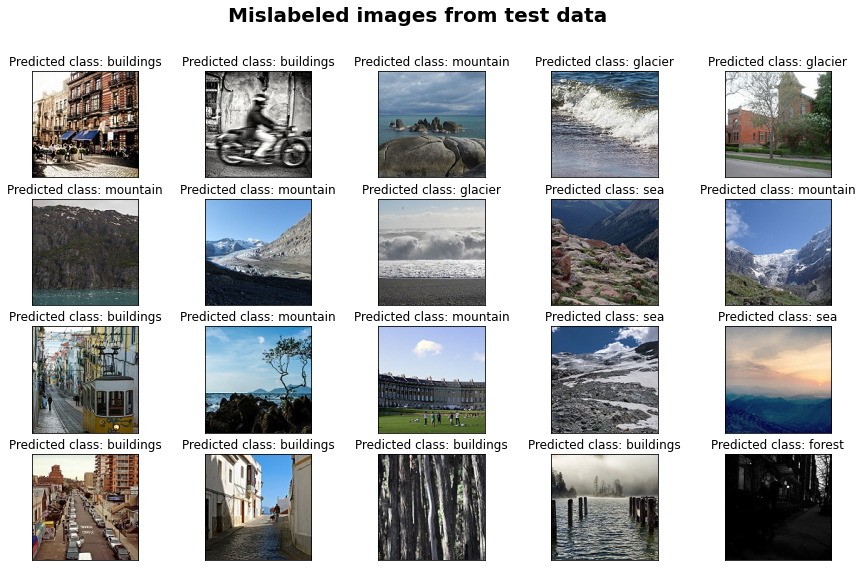

In [32]:
mislables_labels = mislabled_images(class_names, tst_images_norm, test_array, predictions_f)

**NOTE:**

Model confuses between street with buildings and actual building class

Model confuses sea/glacier with mountains and actual mountains. model classifies them as mountains rathar than sea or glacier

It seens reasonable by seeing these variations that why these images are mislabeled. to mitigate this we have to build more deeper NN model with pre-trained base and increse accuracy of classification.

We won't do data augmentation in this problem, as these are the natural scenary images rather than specifics object images.

In [33]:
# next up model using pretrained model vgg16 to improve accuracy to 85-90% and machine visualization